#Import Libraries and Dataset

In [ ]:
#Import Analysis Modules
from datetime import datetime
import time

import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
from numpy import nan, isnan, mean, std, hstack, ravel

from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut, LeavePOut, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Binarizer, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn import tree, ensemble
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_curve, auc, accuracy_score,mean_absolute_error, r2_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics

from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
from scipy.stats import jarque_bera
from scipy.stats import normaltest
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

from statsmodels.tools.eval_measures import mse, rmse

#Import Visualization Modules
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
%matplotlib inline

#Import SciPy
from scipy.sparse import issparse

#Import warning
import warnings
warnings.simplefilter("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
## Read in file
data = pd.read_csv('https://media.githubusercontent.com/media/apham15/large_csv/main/loan.csv',delimiter='~}',na_values='nan')

#Understand the data

In [ ]:
## Count of instances and features
rows, columns = data.shape
print(data.shape)

(42535, 112)


In [ ]:
data.info

<bound method DataFrame.info of             id  member_id  ...  total_il_high_credit_limit  Unnamed: 111
0      1077501    1296599  ...                         NaN           NaN
1      1077430    1314167  ...                         NaN           NaN
2      1077175    1313524  ...                         NaN           NaN
3      1076863    1277178  ...                         NaN           NaN
4      1075358    1311748  ...                         NaN           NaN
...        ...        ...  ...                         ...           ...
42530    73582      73096  ...                         NaN           NaN
42531    72998      72992  ...                         NaN           NaN
42532    72176      70868  ...                         NaN           NaN
42533    71623      70735  ...                         NaN           NaN
42534    70686      70681  ...                         NaN           NaN

[42535 rows x 112 columns]>

In [ ]:
data.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,Unnamed: 111
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687,9.4%,4.0,f,0.0,0.0,1008.710000,1008.71,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956,98.5%,10.0,f,0.0,0.0,3005.666844,3005.67,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
## Get basic statistics for continuous features
numeric = data.describe(include=['number']).T.reset_index()
numeric.rename(columns={'index':'feature'},inplace=True)
numeric.insert(1,'missing',(rows - numeric['count'])/ float(rows))
numeric

,feature,missing,count,mean,std,min,25%,50%,75%,max
0,id,0.0,42535.0,664579.852310,219302.219319,54734.0,498392.5,644250.0,825822.5,1077501.0
1,member_id,0.0,42535.0,825702.551170,279540.905635,70473.0,638479.5,824178.0,1033946.5,1314167.0
2,loan_amnt,0.0,42535.0,11089.722581,7410.938391,500.0,5200.0,9700.0,15000.0,35000.0
3,funded_amnt,0.0,42535.0,10821.585753,7146.914675,500.0,5000.0,9600.0,15000.0,35000.0
4,funded_amnt_inv,0.0,42535.0,10139.830603,7131.686446,0.0,4950.0,8500.0,14000.0,35000.0
...,...,...,...,...,...,...,...,...,...,...
83,tot_hi_cred_lim,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,total_bal_ex_mort,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,total_bc_limit,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,total_il_high_credit_limit,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Distribution of Loan Status in our Dataset')

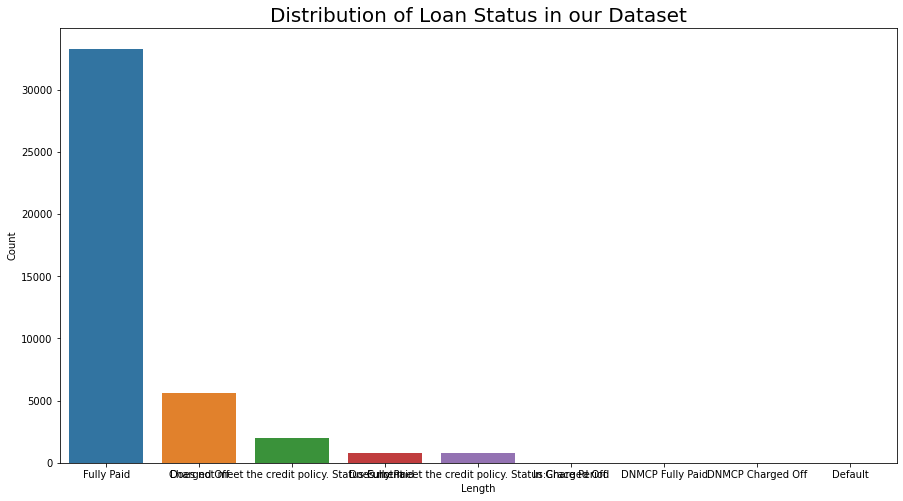

In [ ]:
## Understand of distribution of Loan Status in put Dataset
m = data['loan_status'].value_counts()
m = pd.DataFrame(m)
m.reset_index(level=0, inplace=True)

m['index'][6] = "DNMCP Fully Paid"
m['index'][7] = "DNMCP Charged Off"
m
m.columns = ['Loan Status','Count']
plt.subplots(figsize=(15,8))
sns.barplot(y='Count', x='Loan Status', data=m)
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Loan Status in our Dataset", fontsize=20)


Text(0.5, 1.0, 'Knowing what is in side of the Loan Status')

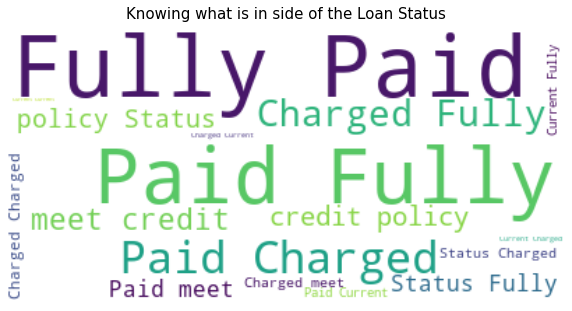

In [ ]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(" ".join(data["loan_status"]))
plt.figure(figsize=(10,7))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Knowing what is in side of the Loan Status", fontsize=15)


In [ ]:
#find out the quartile to understand the distribution
print('1º Quartile: ', data.loan_amnt.quantile(q = 0.25))
print('2º Quartile: ', data.loan_amnt.quantile(q = 0.50))
print('3º Quartile: ', data.loan_amnt.quantile(q = 0.75))
print('4º Quartile: ', data.loan_amnt.quantile(q = 1.00))
print('Ages above: ', data.loan_amnt.quantile(q = 0.75) + 
                      1.5*(data.loan_amnt.quantile(q = 0.75) - data.loan_amnt.quantile(q = 0.25)), 'are outliers')
#Calculate the outliers:
  # Interquartile range, IQR = Q3 - Q1
  # lower 1.5*IQR whisker = Q1 - 1.5 * IQR 
  # Upper 1.5*IQR whisker = Q3 + 1.5 * IQR

1º Quartile:  5200.0
2º Quartile:  9700.0
3º Quartile:  15000.0
4º Quartile:  35000.0
Ages above:  29700.0 are outliers


Text(0.5, 1.0, 'Amount Distribuition Loan Amount')

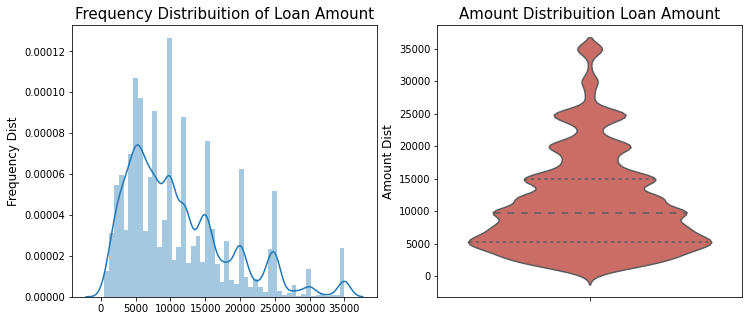

In [ ]:
## Understand the distribution
plt.figure(figsize=(12,5))

plt.subplot(121)
g = sns.distplot(data["loan_amnt"])
g.set_xlabel("", fontsize=12)
g.set_ylabel("Frequency Dist", fontsize=12)
g.set_title("Frequency Distribuition of Loan Amount", fontsize=15)

plt.subplot(122)
g1 = sns.violinplot(y="loan_amnt", data=data, 
               inner="quartile", palette="hls")
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Amount Dist", fontsize=12)
g1.set_title("Amount Distribuition Loan Amount", fontsize=15)

In [ ]:
#adjust interest rate format
data['int_rate'] = data[['int_rate']].applymap(lambda x:str(x).rstrip('%'))
data['int_rate'] = data['int_rate'].astype('float64')

No handles with labels found to put in legend.


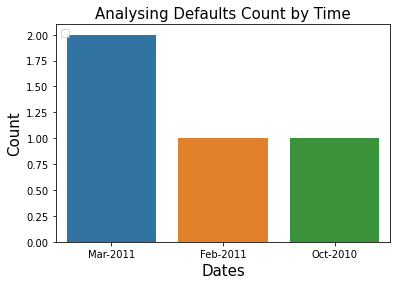

In [ ]:
#Looking the count of defaults though the issue_d that is The month which the loan was funded
g = sns.countplot(x='issue_d', data=data[data['loan_status'] =='Default'])
g.set_xticklabels(g.get_xticklabels(),rotation=0)
g.set_xlabel("Dates", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.legend(loc='upper left')
g.set_title("Analysing Defaults Count by Time", fontsize=15)
plt.show()

Text(0.5, 1.0, 'Evaluation of loan status with loan grade and verified status')

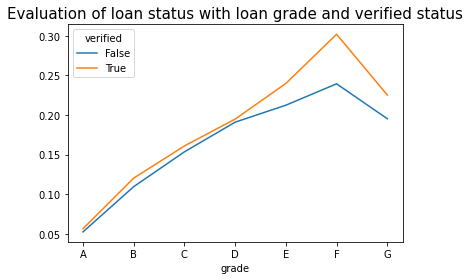

In [ ]:
#Understand the loan status with loan grade and verifired status
data['verified'] = data['verification_status'] == 'Verified'
grade_yr_loanamnt = pd.pivot_table(data,index=["grade","verified"], values=['loan_amnt'], aggfunc=np.sum)

grade_yr_loanamnt_default = pd.pivot_table(data[(data.loan_status == 'Charged Off') | (data.loan_status == 'Default')],
                                           index=["grade","verified"], values=['loan_amnt'], aggfunc=np.sum)

grade_yr_loanamnt_default.columns = ['Charged_off']

loan_verified = pd.merge(grade_yr_loanamnt, grade_yr_loanamnt_default, left_index = True, right_index = True)
loan_verified['chargeoff_rate']  = loan_verified['Charged_off'] /  loan_verified['loan_amnt'] 

loan_verified_unstack = loan_verified.unstack("verified")
verified_chargedoff = loan_verified_unstack['chargeoff_rate']
verified_chargedoff.plot()
plt.title("Evaluation of loan status with loan grade and verified status", fontsize=15)

Text(0.5, 1.0, 'Total committed by Investors')

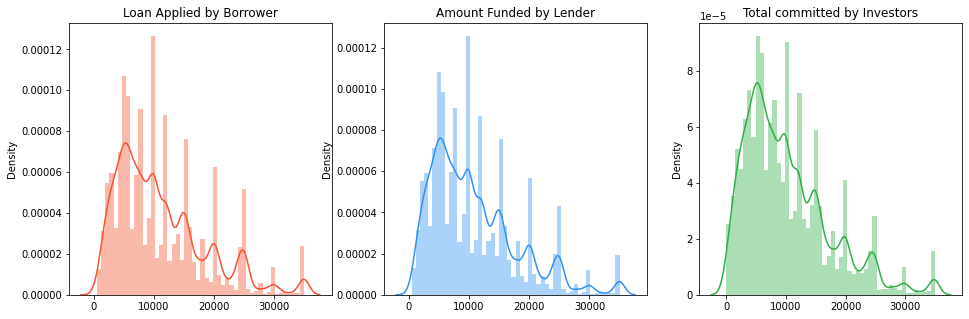

In [ ]:
ig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = data["loan_amnt"].values
funded_amount = data["funded_amnt"].values
investor_funds = data["funded_amnt_inv"].values

sns.distplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by Borrower", fontsize=12)
sns.distplot(funded_amount, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Amount Funded by Lender", fontsize=12)
sns.distplot(investor_funds, ax=ax[2], color="#2EAD46")
ax[2].set_title("Total committed by Investors", fontsize=12)

Most of the loans issued were in the range of 5,000 to 14,000. The loans applied by potential borrowers, the amount issued to the borrowers and the amount funded by investors are similarly distributed, meaning that it is most likely that qualified borrowers are going to get the loan they had applied for.

count    42535.000000
mean     10139.830603
std       7131.686446
min          0.000000
25%       4950.000000
50%       8500.000000
75%      14000.000000
max      35000.000000
Name: funded_amnt_inv, dtype: float64

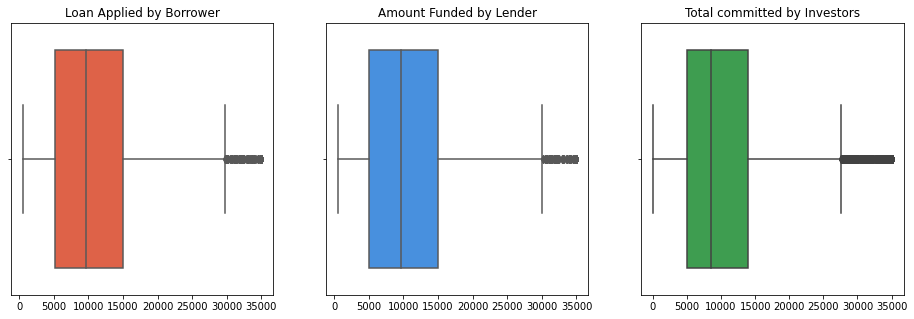

In [ ]:
ig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = data["loan_amnt"].values
funded_amount = data["funded_amnt"].values
investor_funds = data["funded_amnt_inv"].values

sns.boxplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by Borrower", fontsize=12)
sns.boxplot(funded_amount, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Amount Funded by Lender", fontsize=12)
sns.boxplot(investor_funds, ax=ax[2], color="#2EAD46")
ax[2].set_title("Total committed by Investors", fontsize=12)

data['funded_amnt_inv'].describe()

In [ ]:
# Remove rows which have loan status as current as our target column values are Fully Paid and Charged Off
df = data.loc[(data.loan_status != 'Current'), :]
# Determining the loans that are bad from loan_status column

bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
df['loan_condition'] = df['loan_status'].apply(loan_condition)

Text(0, 0.5, '% of Loan Status')

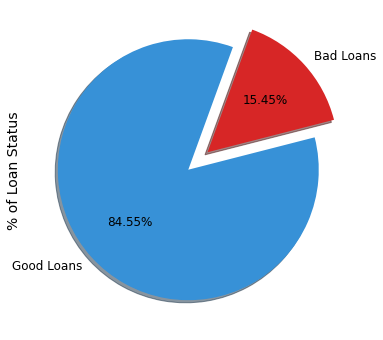

In [ ]:
plt.figure(figsize=(12, 6))
colors = ["#3791D7", "#D72626"]
labels = "Good Loans", "Bad Loans"
df["loan_condition"].value_counts().plot.pie(explode=[0,0.2], autopct='%1.2f%%', shadow=True, colors=colors, labels=labels, fontsize=12, startangle=70)
plt.ylabel('% of Loan Status', fontsize=14)


Fully paid or good loans consist 84.55% of total loans in the cleaned data frame.

Charged off or bad loans consist 15.45% of total loans in the cleaned data frame.

term
 36 months    31534
 60 months    10220
Name: loan_condition, dtype: int64


[Text(0, 0.5, 'Count of Loans'), Text(0.5, 0, 'Term in months')]

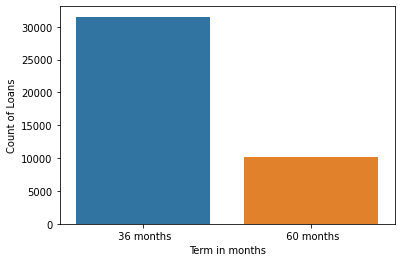

In [ ]:
print(df.groupby("term").loan_condition.count())


ax1 = sns.countplot(x="term", data = df)
ax1.set(xlabel='Term in months', ylabel="Count of Loans")

Most of the loan are 36 months

**After taking a look on dataset, I decided to have more insightful information about loan status with other features that have an impact on loan status. Let's clean the data and eliminate the unneccessary columns.**

#Cleaning data

In [ ]:
## How many features can we eliminate?
drop = numeric[(numeric['missing']==1) | (numeric['std']==0)]
drop

,feature,missing,count,mean,std,min,25%,50%,75%,max
26,collections_12_mths_ex_med,0.003409,42390.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,mths_since_last_major_derog,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,policy_code,0.000000,42535.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
29,annual_inc_joint,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,dti_joint,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,verification_status_joint,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,tot_coll_amt,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,tot_cur_bal,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,open_acc_6m,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,open_il_6m,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## Drop the unhelpful features from the base and numeric table
data = data.drop(drop['feature'],axis=1)
numeric = numeric[~numeric['feature'].isin(drop['feature'])]

In [ ]:
## Double check data
data.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,application_type,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,verified
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jul-2016,INDIVIDUAL,0.0,0.0,0.0,0.0,True
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687,9.4%,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,INDIVIDUAL,0.0,0.0,0.0,0.0,False
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956,98.5%,10.0,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.0,0.00,0.00,Jun-2014,649.91,NaN,Jul-2016,INDIVIDUAL,0.0,0.0,0.0,0.0,False


In [ ]:
## Double check numeric
numeric

,feature,missing,count,mean,std,min,25%,50%,75%,max
0,id,0.000000,42535.0,664579.852310,219302.219319,54734.00,498392.500000,644250.000000,8.258225e+05,1.077501e+06
1,member_id,0.000000,42535.0,825702.551170,279540.905635,70473.00,638479.500000,824178.000000,1.033946e+06,1.314167e+06
2,loan_amnt,0.000000,42535.0,11089.722581,7410.938391,500.00,5200.000000,9700.000000,1.500000e+04,3.500000e+04
3,funded_amnt,0.000000,42535.0,10821.585753,7146.914675,500.00,5000.000000,9600.000000,1.500000e+04,3.500000e+04
4,funded_amnt_inv,0.000000,42535.0,10139.830603,7131.686446,0.00,4950.000000,8500.000000,1.400000e+04,3.500000e+04
5,installment,0.000000,42535.0,322.623063,208.927216,15.67,165.520000,277.690000,4.281800e+02,1.305190e+03
6,annual_inc,0.000094,42531.0,69136.556420,64096.349719,1896.00,40000.000000,59000.000000,8.250000e+04,6.000000e+06
7,dti,0.000000,42535.0,13.373043,6.726315,0.00,8.200000,13.470000,1.868000e+01,2.999000e+01
8,delinq_2yrs,0.000682,42506.0,0.152449,0.512406,0.00,0.000000,0.000000,0.000000e+00,1.300000e+01
9,inq_last_6mths,0.000682,42506.0,1.081424,1.527455,0.00,0.000000,1.000000,2.000000e+00,3.300000e+01


In [ ]:
## Get basic statistics for discrete features
discrete = data.describe(include=['object']).T.reset_index()
discrete.rename(columns={'index':'feature'},inplace=True)
discrete.insert(1,'missing',(rows - discrete['count'])/ float(rows))
discrete

,feature,missing,count,unique,top,freq
0,term,0,42535,2,36 months,31534
1,grade,0,42535,7,B,12389
2,sub_grade,0,42535,35,B3,2997
3,emp_title,0.0617374,39909,30658,US Army,139
4,emp_length,0.0261432,41423,11,10+ years,9369
5,home_ownership,0,42535,5,RENT,20181
6,verification_status,0,42535,3,Not Verified,18758
7,issue_d,0,42535,55,Dec-2011,2267
8,loan_status,0,42535,9,Fully Paid,33314
9,pymnt_plan,0,42535,2,n,42534


In [ ]:
## How many features can we eliminate?
ddrop = discrete[(discrete['missing']>.6) | (discrete['unique']==1)]
ddrop

,feature,missing,count,unique,top,freq
18,initial_list_status,0,42535,1,f,42535
20,next_pymnt_d,0.915811,3581,102,Aug-2016,642
22,application_type,0,42535,1,INDIVIDUAL,42535


In [ ]:
## Drop unhelpful features from the base table
data = data.drop(ddrop['feature'],axis=1)
discrete = discrete[~discrete['feature'].isin(ddrop['feature'])]
data

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,verified
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648,83.7%,9.0,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-2015,171.62,Jul-2016,0.0,0.0,0.0,0.0,True
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687,9.4%,4.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,Sep-2013,0.0,0.0,0.0,0.0,False
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956,98.5%,10.0,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-2014,649.91,Jul-2016,0.0,0.0,0.0,0.0,False
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598,21%,37.0,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-2015,357.48,Apr-2016,0.0,0.0,0.0,0.0,False
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783,53.9%,38.0,335.1,335.1,3716.700000,3716.70,2664.90,1051.80,0.00,0.00,0.00,Aug-2016,67.79,Jul-2016,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42530,73582,73096,3500,3500,225.0,36 months,10.28,113.39,C,C1,NaN,< 1 year,RENT,180000.0,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,https://lendingclub.com/browse/loanDetail.acti...,I am getting married on July 28 and will need ...,other,Wedding coming up,100xx,NY,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,3719.431070,239.11,3500.00,219.43,0.00,0.00,0.00,Mar-2008,0.00,Feb-2013,NaN,NaN,NaN,NaN,False
42531,72998,72992,1000,1000,0.0,36 months,9.64,32.11,B,B4,Halping hands company inc.,< 1 year,RENT,12000.0,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,https://lendingclub.com/browse/loanDetail.acti...,I would like to buy some new furniture in my a...,other,delight,021xx,MA,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,1155.600899,0.00,1000.00,155.60,0.00,0.00,0.00,Jun-2010,32.41,Sep-2014,NaN,NaN,NaN,NaN,False
42532,72176,70868,2525,2525,225.0,36 months,9.33,80.69,B,B3,NaN,< 1 year,RENT,110000.0,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,https://lendingclub.com/browse/loanDetail.acti...,

In [ ]:
##double check discrete
discrete

,feature,missing,count,unique,top,freq
0,term,0,42535,2,36 months,31534
1,grade,0,42535,7,B,12389
2,sub_grade,0,42535,35,B3,2997
3,emp_title,0.0617374,39909,30658,US Army,139
4,emp_length,0.0261432,41423,11,10+ years,9369
5,home_ownership,0,42535,5,RENT,20181
6,verification_status,0,42535,3,Not Verified,18758
7,issue_d,0,42535,55,Dec-2011,2267
8,loan_status,0,42535,9,Fully Paid,33314
9,pymnt_plan,0,42535,2,n,42534


In [ ]:
## Discrete remove
data = data.drop(['grade','sub_grade','int_rate','emp_title','issue_d','pymnt_plan','url','desc','title','earliest_cr_line','last_pymnt_d','last_credit_pull_d'],axis=1)

In [ ]:
data = data.drop(['id','member_id'],axis=1)

In [ ]:
data.shape

(42535, 38)

In [ ]:
## Keep only those loan status where fully paid or charged off
data = data[data['loan_status'].isin(['Fully Paid','Charged Off'])]
#check data
data

,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,verified
0,5000,5000,4975.0,36 months,162.87,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,860xx,AZ,27.65,0.0,1.0,NaN,NaN,3.0,0.0,13648,83.7%,9.0,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,171.62,0.0,0.0,0.0,0.0,True
1,2500,2500,2500.0,60 months,59.83,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,309xx,GA,1.00,0.0,5.0,NaN,NaN,3.0,0.0,1687,9.4%,4.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,0.0,0.0,0.0,False
2,2400,2400,2400.0,36 months,84.33,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,606xx,IL,8.72,0.0,2.0,NaN,NaN,2.0,0.0,2956,98.5%,10.0,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,649.91,0.0,0.0,0.0,0.0,False
3,10000,10000,10000.0,36 months,339.31,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,917xx,CA,20.00,0.0,1.0,35.0,NaN,10.0,0.0,5598,21%,37.0,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,357.48,0.0,0.0,0.0,0.0,False
5,5000,5000,5000.0,36 months,156.46,3 years,RENT,36000.0,Source Verified,Fully Paid,wedding,852xx,AZ,11.20,0.0,3.0,NaN,NaN,9.0,0.0,7963,28.3%,12.0,0.0,0.0,5632.210000,5632.21,5000.00,632.21,0.00,0.00,0.00,161.03,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39781,2500,2500,1075.0,36 months,78.42,4 years,MORTGAGE,110000.0,Not Verified,Fully Paid,home_improvement,802xx,CO,11.33,0.0,0.0,0.0,0.0,13.0,0.0,7274,13.1%,40.0,0.0,0.0,2822.969293,1213.88,2500.00,322.97,0.00,0.00,0.00,80.90,0.0,0.0,NaN,NaN,False
39782,8500,8500,875.0,36 months,275.38,3 years,RENT,18000.0,Not Verified,Fully Paid,credit_card,274xx,NC,6.40,1.0,1.0,5.0,0.0,6.0,0.0,8847,26.9%,9.0,0.0,0.0,9913.491822,1020.51,8500.00,1413.49,0.00,0.00,0.00,281.94,0.0,0.0,NaN,NaN,False
39783,5000,5000,1325.0,36 months,156.84,< 1 year,MORTGAGE,100000.0,Not Verified,Fully Paid,debt_consolidation,017xx,MA,2.30,0.0,0.0,0.0,0.0,11.0,0.0,9698,19.4%,20.0,0.0,0.0,5272.161128,1397.12,5000.00,272.16,0.00,0.00,0.00,0.00,0.0,0.0,NaN,NaN,False
39784,5000,5000,650.0,36 months,155.38,< 1 year,MORTGAGE,200000.0,Not Verified,Fully Paid,other,208xx,MD,3.72,0.0,0.0,0.0,0.0,17.0,0.0,85607,0.7%,26.0,0.0,0.0,5174.198551,672.66,5000.00,174.20,0.00,0.00,0.00,0.00,0.0,0.0,NaN,NaN,False


In [ ]:
#grouping features
sparse_cols = ['delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec',
          'total_acc','out_prncp','out_prncp_inv','total_rec_late_fee','recoveries','collection_recovery_fee', 
          'acc_now_delinq','delinq_amnt','pub_rec_bankruptcies', 'tax_liens']
discrete_cols = ['term','emp_length','home_ownership','verification_status', 'purpose', 
            'zip_code', 'addr_state']

In [ ]:
numeric_cols = [x for x in data.columns if x not in sparse_cols + discrete_cols + ['loan_status']]
#check numeric_cols
numeric_cols

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'annual_inc',
 'dti',
 'revol_bal',
 'revol_util',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'last_pymnt_amnt',
 'verified']

In [ ]:
## Address by stripping leading space
data['term'] = data['term'].str.strip()
data['term']

0        36 months
1        60 months
2        36 months
3        36 months
5        36 months
           ...    
39781    36 months
39782    36 months
39783    36 months
39784    36 months
39785    36 months
Name: term, Length: 38954, dtype: object

In [ ]:
## Scikit learn estimators require numeric features
## Grouping
term_map = {'36 months':0,'60 months':1}
emp_map = {'n/a':0,'< 1 year':1,'1 year':2,'2 years':3,'3 years':4,'4 years':5,'5 years':6,'6 years':7,'7 years':8,'8 years':9,
           '9 years':10, '10 years':11}
status_map = {'Fully Paid':0,'Charged Off':1}

In [ ]:
## Convert categorical features to numeric using mapping function
data['term'] = data['term'].map(term_map)
data['emp_length'] = data['emp_length'].map(emp_map)
data['loan_status'] = data['loan_status'].map(status_map)

In [ ]:
## Double check data
data['term'].isnull().any()

False

In [ ]:
##double check data
data['emp_length'].isnull().any()

True

In [ ]:
##double check data
data['loan_status'].isnull().any()

False

In [ ]:
##fill null value
data['emp_length'].fillna(0.0, inplace=True)
data['emp_length']

0        0.0
1        1.0
2        0.0
3        0.0
5        4.0
        ... 
39781    5.0
39782    4.0
39783    1.0
39784    1.0
39785    1.0
Name: emp_length, Length: 38954, dtype: float64

In [ ]:
#check data
data['revol_util']

0        83.7%
1         9.4%
2        98.5%
3          21%
5        28.3%
         ...  
39781    13.1%
39782    26.9%
39783    19.4%
39784     0.7%
39785    51.5%
Name: revol_util, Length: 38954, dtype: object

In [ ]:
## Leverage regular expressions to clean revol_util and int_rate
data['revol_util'].replace('%','',regex=True,inplace=True)

In [ ]:
## Convert revol_util to numeric 
data['revol_util'] = pd.to_numeric(data['revol_util'])

In [ ]:
## Double check data above
data['revol_util'].isnull().any()

True

In [ ]:
## Fill null value
data['revol_util'].fillna(0.0, inplace=True)

In [ ]:
## Double check
data['revol_util']

0        83.7
1         9.4
2        98.5
3        21.0
5        28.3
         ... 
39781    13.1
39782    26.9
39783    19.4
39784     0.7
39785    51.5
Name: revol_util, Length: 38954, dtype: float64

In [ ]:
validation = data.sample(frac=.2,random_state=12345)
val_x = validation.drop('loan_status',axis=1)
val_y = validation['loan_status'].to_numpy()

In [ ]:
new_data = data.drop(validation.index,axis=0)

In [ ]:
## Seperate input features from target feature
x = new_data.drop('loan_status',axis=1)
y = new_data['loan_status'].to_numpy()

In [ ]:
## Take a look at x
x.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_length,home_ownership,annual_inc,verification_status,purpose,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,verified
0,5000,5000,4975.0,0,162.87,0.0,RENT,24000.0,Verified,credit_card,860xx,AZ,27.65,0.0,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,0.0,0.0,5863.155187,5833.84,5000.0,863.16,0.00,0.0,0.0,171.62,0.0,0.0,0.0,0.0,True
2,2400,2400,2400.0,0,84.33,0.0,RENT,12252.0,Not Verified,small_business,606xx,IL,8.72,0.0,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,0.0,0.0,3005.666844,3005.67,2400.0,605.67,0.00,0.0,0.0,649.91,0.0,0.0,0.0,0.0,False
3,10000,10000,10000.0,0,339.31,0.0,RENT,49200.0,Source Verified,other,917xx,CA,20.00,0.0,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,0.0,0.0,12231.890000,12231.89,10000.0,2214.92,16.97,0.0,0.0,357.48,0.0,0.0,0.0,0.0,False
5,5000,5000,5000.0,0,156.46,4.0,RENT,36000.0,Source Verified,wedding,852xx,AZ,11.20,0.0,3.0,NaN,NaN,9.0,0.0,7963,28.3,12.0,0.0,0.0,5632.210000,5632.21,5000.0,632.21,0.00,0.0,0.0,161.03,0.0,0.0,0.0,0.0,False
7,3000,3000,3000.0,0,109.43,10.0,RENT,48000.0,Source Verified,car,900xx,CA,5.35,0.0,2.0,NaN,NaN,4.0,0.0,8221,87.5,4.0,0.0,0.0,3939.135294,3939.14,3000.0,939.14,0.00,0.0,0.0,111.34,0.0,0.0,0.0,0.0,False


In [ ]:
## Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.3,random_state=15254)

In [ ]:
## Impute missing cases using scikit learn
imp = SimpleImputer(missing_values=np.nan,strategy='most_frequent',fill_value=None, verbose=0, copy=True)
for col in sparse_cols:
    imp.fit(x_train[col].values.reshape(-1,1))
    x_train[col] = imp.transform(x_train[col].values.reshape(-1,1))
    x_test[col] = imp.transform(x_test[col].values.reshape(-1,1))
    val_x[col] = imp.transform(val_x[col].values.reshape(-1,1))

In [ ]:
## MaxAbsScaler
mas = MaxAbsScaler()
for col in sparse_cols:
    mas.fit(x_train[col].values.reshape(-1,1))
    x_train[col] = mas.transform(x_train[col].values.reshape(-1,1))
    x_test[col] = mas.transform(x_test[col].values.reshape(-1,1))
    val_x[col] = mas.transform(val_x[col].values.reshape(-1,1))

In [ ]:
#Apply lable encoder
cols = ['home_ownership','verification_status','purpose','zip_code','addr_state']
le = LabelEncoder()
for col in cols:
    le.fit(ravel(data[col]))
    data[col] = le.transform(ravel(data[col]))
    x_train[col] = le.transform(ravel(x_train[col]))
    x_test[col] = le.transform(ravel(x_test[col]))
    val_x[col] = le.transform(ravel(val_x[col]))

In [ ]:
## Standard histograms with pandas
rb=RobustScaler()
st=StandardScaler()
for col in numeric_cols:
    if col in ['annual_inc','revol_bal']:
        rb.fit(x_train[col].values.reshape(-1,1))
        x_train[col] = rb.transform(x_train[col].values.reshape(-1,1))
        x_test[col] = rb.transform(x_test[col].values.reshape(-1,1))
        val_x[col] = rb.transform(val_x[col].values.reshape(-1,1))
    else:
        st.fit(x_train[col].values.reshape(-1,1))
        x_train[col] = st.transform(x_train[col].values.reshape(-1,1))
        x_test[col] = st.transform(x_test[col].values.reshape(-1,1))
        val_x[col] = st.transform(val_x[col].values.reshape(-1,1))

In [ ]:
#apply ene hot encoder
ohe = OneHotEncoder()
ohe.fit(data.loc[:,discrete_cols])
x_train_discrete = ohe.transform(x_train.loc[:,discrete_cols]).toarray()
x_test_discrete = ohe.transform(x_test.loc[:,discrete_cols]).toarray()
val_discrete = ohe.transform(val_x.loc[:,discrete_cols]).toarray()

#Feature Engineering Process

In [ ]:
## Lets's try to extract components via PCA 
pca = PCA(n_components=5)
pca.fit(x_train.loc[:,numeric_cols])

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
## Transform x
x_train_pca = pca.transform(x_train.loc[:,numeric_cols])
x_test_pca = pca.transform(x_test.loc[:,numeric_cols])
val_x_pca = pca.transform(val_x.loc[:,numeric_cols])

In [ ]:
## Prepare for PCA graphs
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
labels = ['PC' + str(x) for x in range (1, len(per_var)+1)]

Text(0.5, 1.0, 'Scree Plot')

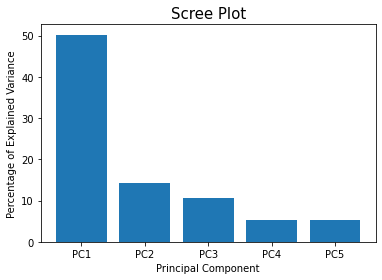

In [ ]:
## PCA Scree Plot
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot', fontsize = 15)

In [ ]:
## Percentage of variance explained by each of the selected components.
print(['%0.3f' % z for z in pca.explained_variance_ratio_]) 

['0.502', '0.142', '0.105', '0.053', '0.052']


PC1 and PC2 account of almost 64% of the variation. PC1 is the highest account, which contains over 50% of the variation

In [ ]:
#visual PCA function
def visualisation_through_PCA(X_PCA, y, model_PCA, model_name="Classification Model"):
    X_set, y_set = X_PCA, y
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                         np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, model_PCA.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.75,cmap = ListedColormap(('tomato', 'palegreen', 'paleturquoise', 'lemonchiffon', 'lavender', 'gainsboro')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ListedColormap(('red', 'green', 'blue', 'yellow', 'purple', 'grey'))(i), label = j)
    plt.title(model_name)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

##Getting deeper train/test sets

In [ ]:
x_train_sparse = x_train.loc[:,sparse_cols].to_numpy()
x_test_sparse = x_test.loc[:,sparse_cols].to_numpy()
val_x_sparse = val_x.loc[:,sparse_cols].to_numpy()

In [ ]:
#final dataset
x_train_final = hstack([x_train_pca, x_train_discrete,x_train_sparse])
x_test_final = hstack([x_test_pca,x_test_discrete,x_test_sparse])
val_x_final = hstack([val_x_pca,val_discrete,val_x_sparse])

In [ ]:
print(x_train_final.shape)
print(x_test_final.shape)
print(val_x_final.shape)
print(y_train.shape)
print(y_test.shape)


(21814, 928)
(9349, 928)
(7791, 928)
(21814,)
(9349,)


#Machine Learning Algorithms

##Logistic Regression

In [ ]:
# We create a LogisticRegression model object
logreg = LogisticRegression()

#Scikit Kfold model call
cross_val = KFold(n_splits=3, random_state=42)

#fitting dataset
logreg.fit(x_train_final, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#make a prediction on test dataset
log_predictions_test = logreg.predict(x_test_final)

#Print prediction
print("Predictions:",log_predictions_test[:10])
print("\nActual:",y_test[:10])

#returns the matrix of probabilities that the predicted output is equal to zero or one
print("\nProbabilities of the predicted output:",logreg.predict_proba(x_test_final))


Predictions: [0 0 0 0 0 0 0 1 0 0]

Actual: [0 0 0 0 0 0 1 1 1 0]

Probabilities of the predicted output: [[0.93422685 0.06577315]
 [0.99298157 0.00701843]
 [0.68903555 0.31096445]
 ...
 [0.65743475 0.34256525]
 [0.8665281  0.1334719 ]
 [0.99123288 0.00876712]]


In [ ]:
#testing over-fitting
print("Train Accuracy:",logreg.score(x_train_final, y_train))
print("Test Accuracy:",logreg.score(x_test_final, y_test))

Train Accuracy: 0.8884202805537728
Test Accuracy: 0.8815916140763718


Train and Test sets have the same R-square, which indicate that there is no overfitting

In [ ]:
#Let's see how our model performed on test dataset
print(classification_report(y_test, log_predictions_test))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      7987
           1       0.74      0.29      0.42      1362

    accuracy                           0.88      9349
   macro avg       0.81      0.64      0.68      9349
weighted avg       0.87      0.88      0.86      9349



1.   For Precision
* there are 89% Good Loan as the prediction correctly
* there are 74% Bad Loan as the prediction correctly 
2.   For Recall
* there are 98% positive  Good Loan cases that were catched
* there are 29% positive Bad Loan cases that were catched
3. For F1-score
* there are 93%  Good Loan of positive predictions were correct
* there are 42% Bad Loann of positive predictions were correct

4. Accuracy is 0.88

In [ ]:
#get more information on the accuracy of the model with a confusion matrix
#create the confusion matrix
cm = confusion_matrix(y_test, log_predictions_test)

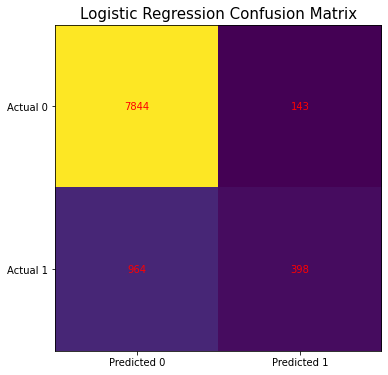

In [ ]:
#visuallize the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0', 'Predicted 1'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0', 'Actual 1'))
ax.set_title('Logistic Regression Confusion Matrix', fontsize=15)

ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

In [ ]:
## Get data to plot ROC Curve
fp, tp, th = roc_curve(y_test, log_predictions_test)
roc_auc_log = auc(fp, tp)

Area under the ROC curve: 0.637


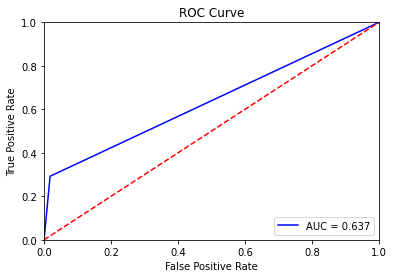

In [ ]:
## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fp, tp, 'b',
label='AUC = %0.3f'% roc_auc_log)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

print('Area under the ROC curve: {:.3f}'.format(roc_auc_log))

In [ ]:
#find the mean of cross validation score
mean_auc_log = mean(cross_val_score(logreg, x_train_final, y_train, cv=cross_val, scoring='roc_auc'))
print("The mean of Logistic Regression's accuracy score is: {}".format(mean_auc_log))

The mean of Logistic Regression's accuracy score is: 0.8452266312671122


##Decision Tree Model

In [ ]:
## Create estimator
dtc = DecisionTreeClassifier(class_weight='balanced',max_depth=3, max_features= 'log2')

#Scikit Kfold model call
cross_val = KFold(n_splits=3, random_state=42)

#fitting model
dtc.fit(x_train_final, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=3, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
#Prediction
dtc_prediction_test = dtc.predict(x_test_final)

#Print prediction
print("Predictions:",dtc_prediction_test[:10])
print("\nActual:",y_test[:10])

#returns the matrix of probabilities that the predicted output is equal to zero or one
print("\nProbabilities of the predicted output:",dtc.predict_proba(x_test_final))

Predictions: [0 0 0 0 1 0 1 0 0 1]

Actual: [0 0 0 0 0 0 1 1 1 0]

Probabilities of the predicted output: [[0.5636431  0.4363569 ]
 [0.5636431  0.4363569 ]
 [0.5636431  0.4363569 ]
 ...
 [0.5636431  0.4363569 ]
 [0.46004825 0.53995175]
 [0.5636431  0.4363569 ]]


In [ ]:
#test accuracy
print("Train Accuracy is : {}".format(dtc.score(x_train_final, y_train)))
print("Test Accuracy is: {}".format(dtc.score(x_test_final,y_test)))

Train Accuracy is : 0.49330705051801593
Test Accuracy is: 0.4965236923735159


Train set and Test set have simnilar R-square. There is no need to do regularization

[Text(697.5, 475.65000000000003, 'X[724] <= 0.5\ngini = 0.5\nsamples = 21814\nvalue = [10907.0, 10907.0]'),
 Text(558.0, 339.75, 'X[871] <= 0.5\ngini = 0.5\nsamples = 21809\nvalue = [10904.078, 10907.0]'),
 Text(279.0, 203.85000000000002, 'X[913] <= 0.062\ngini = 0.5\nsamples = 20218\nvalue = [10144.416, 9899.081]'),
 Text(139.5, 67.94999999999999, 'gini = 0.492\nsamples = 9721\nvalue = [5024.291, 3889.667]'),
 Text(418.5, 67.94999999999999, 'gini = 0.497\nsamples = 10497\nvalue = [5120.125, 6009.414]'),
 Text(837.0, 203.85000000000002, 'X[27] <= 0.5\ngini = 0.49\nsamples = 1591\nvalue = [759.662, 1007.919]'),
 Text(697.5, 67.94999999999999, 'gini = 0.488\nsamples = 1407\nvalue = [667.334, 917.864]'),
 Text(976.5, 67.94999999999999, 'gini = 0.5\nsamples = 184\nvalue = [92.328, 90.055]'),
 Text(837.0, 339.75, 'gini = 0.0\nsamples = 5\nvalue = [2.922, 0.0]')]

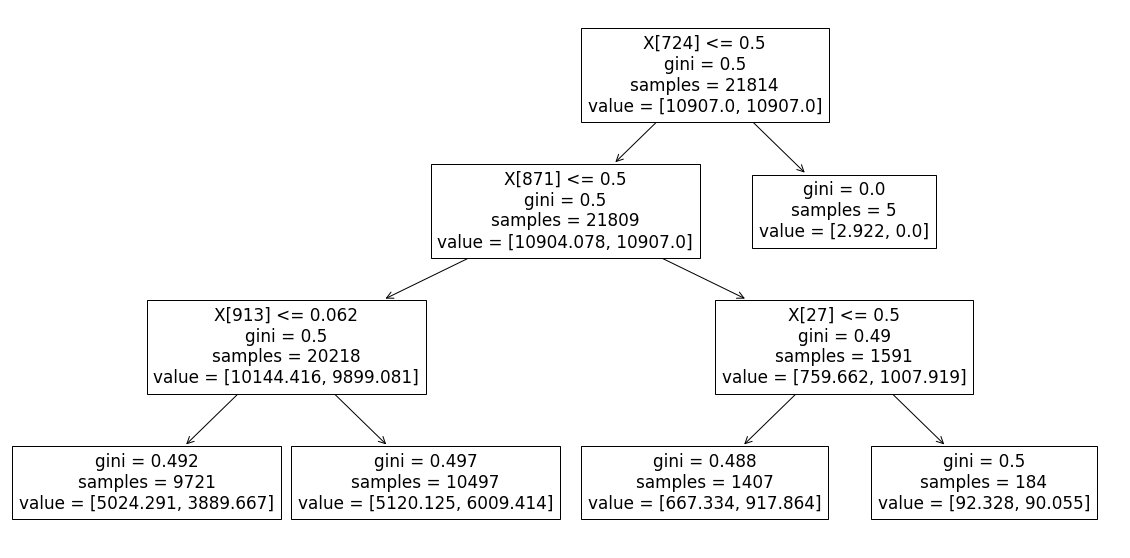

In [ ]:
## Decision Tree Plot
plt.figure(figsize=(20,10))
tree.plot_tree(dtc)

In [ ]:
#Let's see how our model performed
print(classification_report(y_test, dtc_prediction_test))

              precision    recall  f1-score   support

           0       0.88      0.48      0.62      7987
           1       0.17      0.62      0.26      1362

    accuracy                           0.50      9349
   macro avg       0.52      0.55      0.44      9349
weighted avg       0.78      0.50      0.57      9349



1.   For Precision
* there are 88% Good Loan as the prediction correctly
* there are 17% Bad Loan as the prediction correctly 
2.   For Recall
* there are 48% positive  Good Loan cases that were catched
* there are 62% positive Bad Loan cases that were catched
3. For F1-score
* there are 62%  Good Loan of positive predictions were correct
* there are 26% Bad Loann of positive predictions were correct

4. Accuracy is 0.50

In [ ]:
#get more information on the accuracy of the model with a confusion matrix
#create the confusion matrix
cm = confusion_matrix(y_test, dtc_prediction_test)

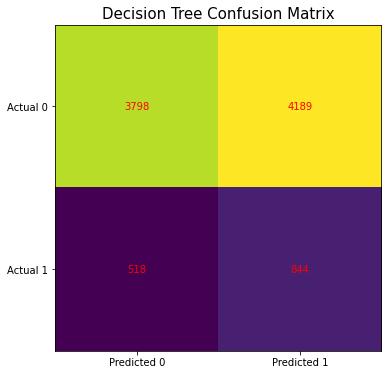

In [ ]:
#visuallize the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0', 'Predicted 1'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0', 'Actual 1'))
ax.set_title('Decision Tree Confusion Matrix', fontsize=15)

ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

In [ ]:
## Get data to plot ROC Curve
fp, tp, th = roc_curve(y_test, dtc_prediction_test)
roc_auc_dtc = auc(fp, tp)

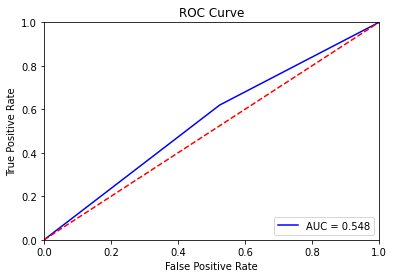

Area under the ROC curve: 0.548


In [ ]:
## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fp, tp, 'b',
label='AUC = %0.3f'% roc_auc_dtc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('Area under the ROC curve: {:.3f}'.format(roc_auc_dtc))

In [ ]:
#find the mean of auc score
mean_auc_dtc = mean(cross_val_score(dtc,x_test_final,y_test, cv=cross_val, scoring='roc_auc'))
print("The mean of Decision Tree classifier's accuracy score is: {}".format(mean_auc_dtc))


The mean of Decision Tree classifier's accuracy score is: 0.6112295382601048


##Random Forest Classifier


In [ ]:
## Create estimator
rfc = ensemble.RandomForestClassifier(criterion = 'entropy', max_features= 'auto', n_estimators=50)
                      
#Scikit Kfold model call
cross_val = KFold(n_splits=3, random_state=42)

#fitting model
rfc.fit(x_train_final, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#Prediction
rfc_predictions_test = rfc.predict(x_test_final)

#Print prediction
print("\nPredictions:",rfc_predictions_test[:10])
print("\nActual:",y_test[:10])

#returns the matrix of probabilities that the predicted output is equal to zero or one
print("\nProbabilities of the predicted output:",rfc.predict_proba(x_test_final))


Predictions: [0 0 0 0 0 0 1 1 1 0]

Actual: [0 0 0 0 0 0 1 1 1 0]

Probabilities of the predicted output: [[1.   0.  ]
 [0.96 0.04]
 [0.86 0.14]
 ...
 [0.84 0.16]
 [0.98 0.02]
 [0.98 0.02]]


In [ ]:
#test overfiting
print("Train Accuracy: {}".format(rfc.score(x_train_final, y_train)))
print("Test Accuracy: {}".format(rfc.score(x_test_final, y_test)))

Train Accuracy: 0.9994957366828642
Test Accuracy: 0.9625628409455557


Train set and Test set have simnilar R-square. There is no need to do regularization

In [ ]:
#Let's see how our model performed
print(classification_report(y_test, rfc_predictions_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7987
           1       1.00      0.74      0.85      1362

    accuracy                           0.96      9349
   macro avg       0.98      0.87      0.92      9349
weighted avg       0.96      0.96      0.96      9349



1. For Precision
* there are 96% Good Loan as the prediction correctly
* there are 100% Bad Loan as the prediction correctly
2. For Recall
* there are 100% positive Good Loan cases that were catched
* there are 75% positive Bad Loan cases that were catched
3. For F1-score
* there are 98% Good Loan of positive predictions were correct
* there are 85% Bad Loann of positive predictions were correct
4. Accuracy is 0.96

In [ ]:
#get more information on the accuracy of the model with a confusion matrix
#create the confusion matrix
cm = confusion_matrix(y_test, rfc_predictions_test)

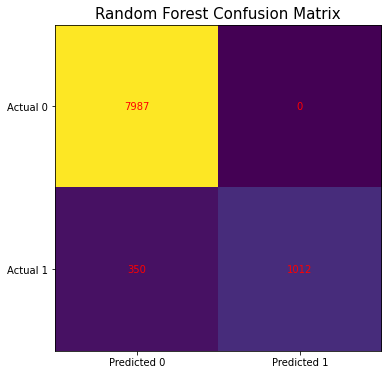

In [ ]:
#visuallize the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0', 'Predicted 1'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0', 'Actual 1'))
ax.set_title('Random Forest Confusion Matrix', fontsize=15)

ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

In [ ]:
## Get data to plot ROC Curve
fp, tp, th = roc_curve(y_test, rfc_predictions_test)
roc_auc_rfc = roc_auc_score(y_test, rfc_predictions_test)

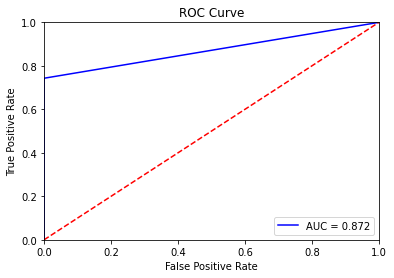

Area under the ROC curve: 0.872


In [ ]:
## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fp, tp, 'b',
label='AUC = %0.3f'% roc_auc_rfc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('Area under the ROC curve: {:.3f}'.format(roc_auc_rfc))

In [ ]:
#find the mean of auc score
mean_auc_rfc = mean(cross_val_score(rfc,x_test_final,y_test, cv=cross_val, scoring='roc_auc'))
print("The mean of Random Forest classifier's accuracy score is: {}".format(mean_auc_rfc))

The mean of Random Forest classifier's accuracy score is: 0.9350749477478381


##KNeighbor Classifier

In [ ]:
# from scikit-learn module.
neighbors= KNeighborsClassifier()

#Scikit Kfold model call
cross_val = KFold(n_splits=3, random_state=42)

#fitting model
neighbors.fit(x_train_final, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
#make a prediction on test dataset
neighbors_predictions_test = neighbors.predict(x_test_final)

#Print prediction
print("Predictions:",neighbors_predictions_test[:10])
print("\nActual:",y_test[:10])

#returns the matrix of probabilities that the predicted output is equal to zero or one
print("\nProbabilities of the predicted output:",neighbors.predict_proba(x_test_final))


Predictions: [0 0 0 0 0 0 0 1 1 0]

Actual: [0 0 0 0 0 0 1 1 1 0]

Probabilities of the predicted output: [[0.8 0.2]
 [1.  0. ]
 [0.8 0.2]
 ...
 [0.6 0.4]
 [0.8 0.2]
 [1.  0. ]]


In [ ]:
#test overfiting
print("Train Accuracy: {}".format(neighbors.score(x_train_final, y_train)))
print("Test Accuracy: {}".format(neighbors.score(x_test_final, y_test)))

Train Accuracy: 0.8836985422205923
Test Accuracy: 0.8503583270938069


Train and Test dataset have pretty similar R-square scores, which indicite that there is no over fitting

In [ ]:
#Let's see how our model performed
print(classification_report(y_test, neighbors_predictions_test))

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      7987
           1       0.47      0.18      0.26      1362

    accuracy                           0.85      9349
   macro avg       0.67      0.57      0.59      9349
weighted avg       0.81      0.85      0.82      9349



1. For Precision
* there are 87% Good Loan as the prediction correctly
* there are 47% Bad Loan as the prediction correctly
2. For Recall
* there are 96% positive Good Loan cases that were catched
* there are 18% positive Bad Loan cases that were catched
3. For F1-score
* there are 92% Good Loan of positive predictions were correct
* there are 26% Bad Loann of positive predictions were correct
4. Accuracy is 0.85

In [ ]:
#get more information on the accuracy of the model with a confusion matrix
#create the confusion matrix
cm = confusion_matrix(y_test, neighbors_predictions_test)

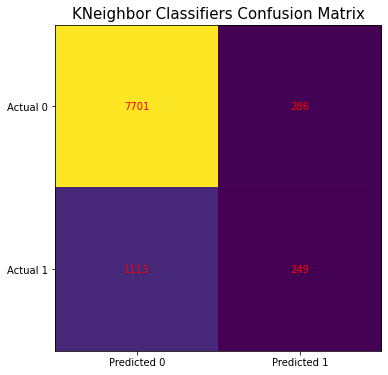

In [ ]:
#visuallize the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0', 'Predicted 1'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0', 'Actual 1'))
ax.set_title('KNeighbor Classifiers Confusion Matrix', fontsize=15)

ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

In [ ]:
## Get data to plot ROC Curve
fp, tp, th = roc_curve(y_test, neighbors_predictions_test)
roc_auc_knn = roc_auc_score(y_test, neighbors_predictions_test)

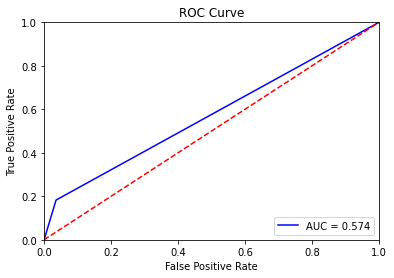

Area under the ROC curve: 0.574


In [ ]:
## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fp, tp, 'b',
label='AUC = %0.3f'% roc_auc_knn)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('Area under the ROC curve: {:.3f}'.format(roc_auc_knn))

In [ ]:
#find the mean of auc score
mean_auc_knn = mean(cross_val_score(neighbors,x_test_final,y_test, cv=cross_val, scoring='roc_auc'))
print("The mean of KNeighbor classifier's accuracy score is: {}".format(mean_auc_knn))

The mean of KNeighbor classifier's accuracy score is: 0.669848529372734


##Support Vector Classifier

In [ ]:
## Create estimator
svc = SVC()

#Scikit Kfold model call
cross_val = KFold(n_splits=3, random_state=42)

#fitting model
svc.fit(x_train_final, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
#Prediction
svc_predictions_test = svc.predict(x_test_final)

#Print prediction
print("\nPredictions:",svc_predictions_test[:10])
print("\nActual:",y_test[:10])



Predictions: [0 0 0 0 0 0 0 1 0 0]

Actual: [0 0 0 0 0 0 1 1 1 0]


In [ ]:
#test accuracy
print("Train Accuracy is : {}".format(svc.score(x_train_final, y_train)))
print("Test Accuracy is: {}".format(svc.score(x_test_final ,y_test)))

Train Accuracy is : 0.8736591179976162
Test Accuracy is: 0.8670446037009306


Train and Test dataset have pretty similar R-square scores, which indicite that there is no over fitting

In [ ]:
#Let's see how our model performed
print(classification_report(y_test, svc_predictions_test))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93      7987
           1       0.76      0.13      0.22      1362

    accuracy                           0.87      9349
   macro avg       0.81      0.56      0.57      9349
weighted avg       0.85      0.87      0.82      9349



1. For Precision
* there are 87% Good Loan as the prediction correctly
* there are 76% Bad Loan as the prediction correctly
2. For Recall
* there are 99% positive Good Loan cases that were catched
* there are 13% positive Bad Loan cases that were catched
3. For F1-score
* there are 93% Good Loan of positive predictions were correct
* there are 22% Bad Loann of positive predictions were correct
4. Accuracy is 0.87

In [ ]:
#get more information on the accuracy of the model with a confusion matrix
#create the confusion matrix
cm = confusion_matrix(y_test, svc_predictions_test)

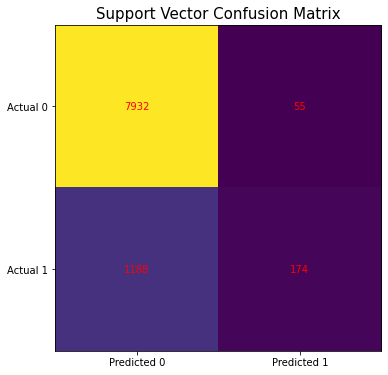

In [ ]:
#visuallize the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0', 'Predicted 1'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0', 'Actual 1'))
ax.set_title('Support Vector Confusion Matrix', fontsize=15)

ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

In [ ]:
## Get data to plot ROC Curve
fp, tp, th = roc_curve(y_test, svc_predictions_test)
auc_svc = roc_auc_score(y_test, svc_predictions_test)

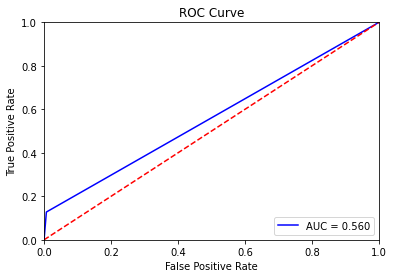

Area under the ROC curve: 0.560


In [ ]:
## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fp, tp, 'b',
label='AUC = %0.3f'% auc_svc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('Area under the ROC curve: {:.3f}'.format(auc_svc))

In [ ]:
#find the mean of auc score
mean_auc_svc = mean(cross_val_score(svc,x_test_final,y_test, cv=cross_val, scoring='roc_auc'))
print("The mean of Support Vector classifier's accuracy score is: {}".format(mean_auc_svc))

The mean of Support Vector classifier's accuracy score is: 0.8146859035528262


##Naive Bayes

In [ ]:
## Create estimator
naive_bayes = GaussianNB()

#Scikit Kfold model call
cross_val = KFold(n_splits=3, random_state=42)

#fitting model
naive_bayes.fit(x_train_final, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
#Prediction
naive_bayes_predictions_test = naive_bayes.predict(x_test_final)

#Print prediction
print("\nPredictions:",naive_bayes_predictions_test[:10])
print("\nActual:",y_test[:10])



Predictions: [1 0 1 1 1 1 1 1 1 1]

Actual: [0 0 0 0 0 0 1 1 1 0]


In [ ]:
#test accuracy
print("Train Accuracy is : {}".format(naive_bayes.score(x_train_final, y_train)))
print("Test Accuracy is: {}".format(naive_bayes.score(x_test_final ,y_test)))

Train Accuracy is : 0.20097185293847988
Test Accuracy is: 0.19403144721360574


Train and test dataset have similar R-squares, which means there is no over fitting

In [ ]:
#Let's see how our model performed
print(classification_report(y_test, naive_bayes_predictions_test))

              precision    recall  f1-score   support

           0       0.88      0.07      0.12      7987
           1       0.15      0.95      0.26      1362

    accuracy                           0.19      9349
   macro avg       0.51      0.51      0.19      9349
weighted avg       0.77      0.19      0.14      9349



1. For Precision
* there are 88% Good Loan as the prediction correctly
* there are 15% Bad Loan as the prediction correctly
2. For Recall
* there are 7% positive Good Loan cases that were catched
* there are 95% positive Bad Loan cases that were catched
3. For F1-score
* there are 12% Good Loan of positive predictions were correct
* there are 26% Bad Loann of positive predictions were correct
4. Accuracy is 0.19

In [ ]:
#get more information on the accuracy of the model with a confusion matrix
#create the confusion matrix
cm = confusion_matrix(y_test, naive_bayes_predictions_test)

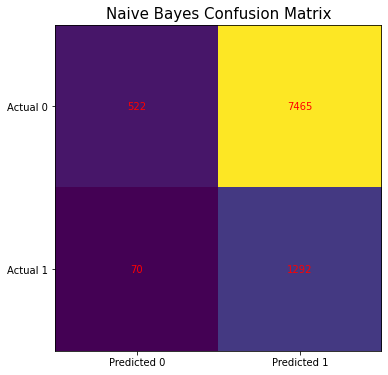

In [ ]:
#visuallize the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0', 'Predicted 1'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0', 'Actual 1'))
ax.set_title('Naive Bayes Confusion Matrix', fontsize=15)

ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
      ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

In [ ]:
## Get data to plot ROC Curve
fp, tp, th = roc_curve(y_test, naive_bayes_predictions_test)
auc_naive = roc_auc_score(y_test, naive_bayes_predictions_test)

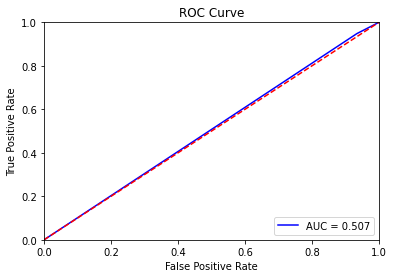

Area under the ROC curve: 0.507


In [ ]:
## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fp, tp, 'b',
label='AUC = %0.3f'% auc_naive)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('Area under the ROC curve: {:.3f}'.format(auc_naive))

In [ ]:
#find the mean of auc score
mean_auc_naive = mean(cross_val_score(naive_bayes,x_test_final,y_test, cv=cross_val, scoring='roc_auc'))
print("The mean of Naive Bayes classifier's accuracy score is: {}".format(mean_auc_naive))

The mean of Naive Bayes classifier's accuracy score is: 0.5089241041002666


##Boosting Models


In [ ]:
## Create estimator
boosting =  ensemble.GradientBoostingClassifier()

#Scikit Kfold model call
cross_val = KFold(n_splits=3, random_state=42)

#fitting model
boosting.fit(x_train_final, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
#Prediction
boosting_predictions_test = boosting.predict(x_test_final)

#Print prediction
print("\nPredictions:",boosting_predictions_test[:10])
print("\nActual:",y_test[:10])



Predictions: [0 0 0 0 0 0 1 1 1 0]

Actual: [0 0 0 0 0 0 1 1 1 0]


In [ ]:
#test accuracy
print("Train Accuracy is : {}".format(boosting.score(x_train_final, y_train)))
print("Test Accuracy is: {}".format(boosting.score(x_test_final ,y_test)))

Train Accuracy is : 0.9667186210690383
Test Accuracy is: 0.9630976575034763


Train and test sets have the same R-square, which indicates that both sets are fitted

In [ ]:
#Let's see how our model performed
print(classification_report(y_test, boosting_predictions_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7987
           1       0.99      0.75      0.86      1362

    accuracy                           0.96      9349
   macro avg       0.98      0.88      0.92      9349
weighted avg       0.96      0.96      0.96      9349



1. For Precision
* there are 96% Good Loan as the prediction correctly
* there are 99% Bad Loan as the prediction correctly
2. For Recall
* there are 100% positive Good Loan cases that were catched
* there are 75% positive Bad Loan cases that were catched
3. For F1-score
* there are 98% Good Loan of positive predictions were correct
* there are 86% Bad Loann of positive predictions were correct
4. Accuracy is 0.96

In [ ]:
#get more information on the accuracy of the model with a confusion matrix
#create the confusion matrix
cm = confusion_matrix(y_test, boosting_predictions_test)

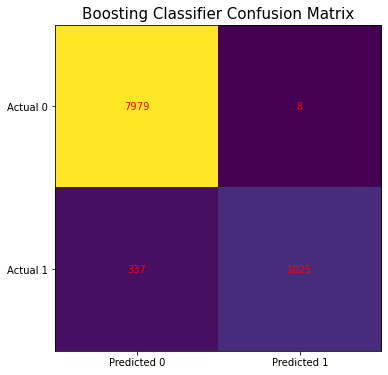

In [ ]:
#visuallize the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0', 'Predicted 1'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0', 'Actual 1'))
ax.set_title('Boosting Classifier Confusion Matrix', fontsize=15)

ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
      ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

In [ ]:
## Get data to plot ROC Curve
fp, tp, th = roc_curve(y_test, boosting_predictions_test)
auc_boosting = roc_auc_score(y_test, boosting_predictions_test)

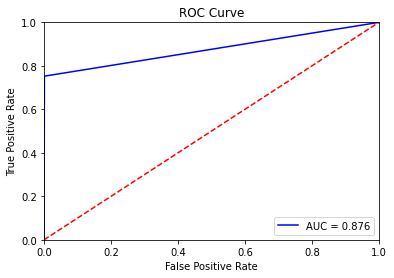

Area under the ROC curve: 0.876


In [ ]:
## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fp, tp, 'b',
label='AUC = %0.3f'% auc_boosting)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('Area under the ROC curve: {:.3f}'.format(auc_boosting))

In [ ]:
#find the mean of auc score
mean_auc_boosting = mean(cross_val_score(boosting,x_test_final,y_test, cv=cross_val, scoring='roc_auc'))
print("The mean of Boosting classifier's accuracy score is: {}".format(mean_auc_boosting))

The mean of Boosting classifier's accuracy score is: 0.9482613966582799


#Determine the best model

In [ ]:
#create dataframe to store the auc
best_model = pd.DataFrame([['Logistic Regresion',mean_auc_log,roc_auc_log],
                          ['K Nearest Neighbor', mean_auc_knn, roc_auc_knn],
                          ['Decision Tree', mean_auc_dtc,roc_auc_dtc],
                          ['Random Forest', mean_auc_rfc,roc_auc_rfc],
                          ['Support Vector', mean_auc_svc,auc_svc],
                          ['Naive Bayes', mean_auc_naive, auc_naive],
                          ['Boosting Classifier', mean_auc_boosting, auc_boosting]],
                          columns = ["Classifier_Model",'Mean_Cross_val_score', 'AUC']
                          )
best_model

,Classifier_Model,Mean_Cross_val_score,AUC
0,Logistic Regresion,0.845227,0.637157
1,K Nearest Neighbor,0.669849,0.573506
2,Decision Tree,0.611230,0.547600
3,Random Forest,0.935075,0.871512
4,Support Vector,0.814686,0.560434
5,Naive Bayes,0.508924,0.506981
6,Boosting Classifier,0.948261,0.875784


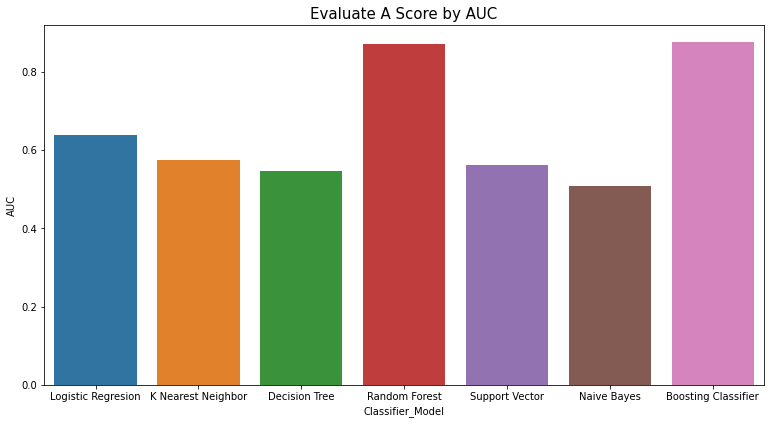

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
x = best_model.Classifier_Model
y = best_model.AUC
plt.title ('Evaluate A Score by AUC',fontsize=15)
sns.barplot(x=x, y=y)

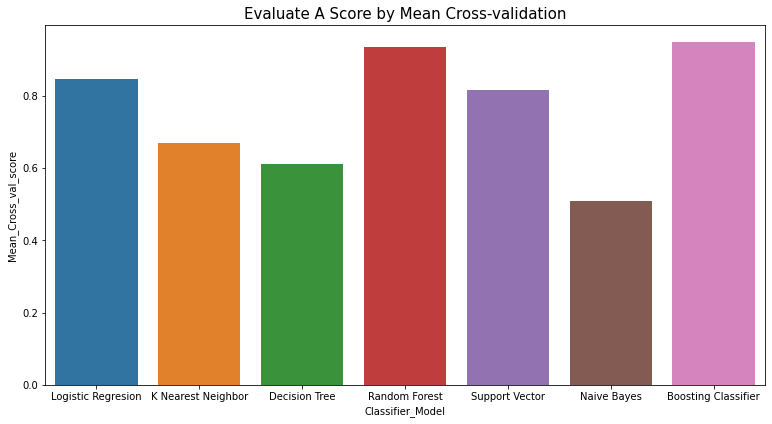

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
x = best_model.Classifier_Model
y = best_model.Mean_Cross_val_score
plt.title ('Evaluate A Score by Mean Cross-validation',fontsize=15)
sns.barplot(x=x, y=y)

According to the mean cross validation report above, the best model is Boosing Classifier, which also has the highest AUC score. However, the mean cross validation score and AUC of Random Forest are high. As a result, I apply GidSearchCV to find the best Parameters for two models.

##Apply GridSearchCV for GBM Model


Create Parameters

In [ ]:
# Number of trees
n_estimators = [int(x) for x in np.linspace(15, 50, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 15, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [5, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 15]

#create parameter
parameters = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              }

print(parameters)


{'n_estimators': [15, 23, 32, 41, 50], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [5, 7, 10, 12, 15], 'min_samples_split': [5, 15], 'min_samples_leaf': [5, 15]}


In [ ]:
#Create estimator
clf1 = ensemble.GradientBoostingClassifier()

##adding GridsearchCV to define the best parameter
clf1_gridsearch = GridSearchCV(clf1, parameters)

## Fit the model using training set 
clf1_gridsearch.fit(x_train_final,y_train)

#Fiding the best parameter
best_clf1_model = clf1_gridsearch.best_params_

In [ ]:
#print out the best model
best_clf1_model

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 5,
 'n_estimators': 41}

In [ ]:
#prediction
clf1_prediction = clf1_gridsearch.predict(x_train_final)

In [ ]:
#Test acuracy
print("Train Accuracy is : {}".format(clf1_gridsearch.score(x_train_final, y_train)))
print("Test Accuracy is: {}".format(clf1_gridsearch.score(x_test_final ,y_test)))

Train Accuracy is : 0.9861556798386357
Test Accuracy is: 0.9630976575034763


In [ ]:
#Let's see how our model performed
print(classification_report(y_train, clf1_prediction))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18665
           1       1.00      0.90      0.95      3149

    accuracy                           0.99     21814
   macro avg       0.99      0.95      0.97     21814
weighted avg       0.99      0.99      0.99     21814



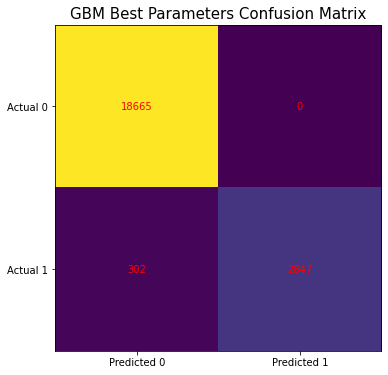

In [ ]:
#get more information on the accuracy of the model with a confusion matrix
#create the confusion matrix
cm = confusion_matrix(y_train, clf1_prediction)

#visuallize the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0', 'Predicted 1'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0', 'Actual 1'))
ax.set_title('GBM Best Parameters Confusion Matrix', fontsize=15)

ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

Area under the ROC curve: 1.000


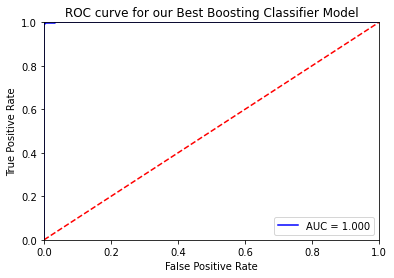

In [ ]:
#probability
proba = clf1_gridsearch.predict_proba(x_train_final)

# Producing the same false/true positive data via a library and plotting it
fpr, tpr, _ = metrics.roc_curve(y_train,proba[:,1])
auc_boosting_best = metrics.roc_auc_score(y_train,proba[:,1])


## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.3f'% auc_boosting_best)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC curve for our Best Boosting Classifier Model")

print('Area under the ROC curve: {:.3f}'.format(auc_boosting_best))

##Apply GridSearchCV for Random Foest


In [ ]:
#parameter
# Number of trees
n_estimators = [int(x) for x in np.linspace(15, 50, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(15, 30, num = 4)]
#criterion
criterion = ['entropy', 'gini']
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 12]
# Method of selecting samples for training each tree
bootstrap = [True, False]

#create parameter
parameters = {'criterion' : criterion,
              'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

print(parameters)


{'criterion': ['entropy', 'gini'], 'n_estimators': [15, 26, 38, 50], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [15, 20, 25, 30], 'min_samples_split': [5, 10], 'min_samples_leaf': [4, 12], 'bootstrap': [True, False]}


In [ ]:
#Create estimator
clf2 = ensemble.RandomForestClassifier()

##adding GridsearchCV to define the best parameter
clf2_gridsearch = GridSearchCV(clf2, parameters)

## Fit the model using training set 
clf2_gridsearch.fit(x_train_final,y_train)

#Fiding the best parameter
best_clf2_model = clf2_gridsearch.best_params_

In [ ]:
#print out the best model
best_clf2_model

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 50}

In [ ]:
#prediction
clf2_prediction = clf2_gridsearch.predict(x_train_final)

In [ ]:
#Test acuracy
print("Train Accuracy is : {}".format(clf2_gridsearch.score(x_train_final, y_train)))
print("Test Accuracy is: {}".format(clf2_gridsearch.score(x_test_final ,y_test)))

Train Accuracy is : 0.9643348308425782
Test Accuracy is: 0.9614932078297144


In [ ]:
#Let's see how our model performed
print(classification_report(y_train, clf2_prediction))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18665
           1       1.00      0.75      0.86      3149

    accuracy                           0.96     21814
   macro avg       0.98      0.88      0.92     21814
weighted avg       0.97      0.96      0.96     21814



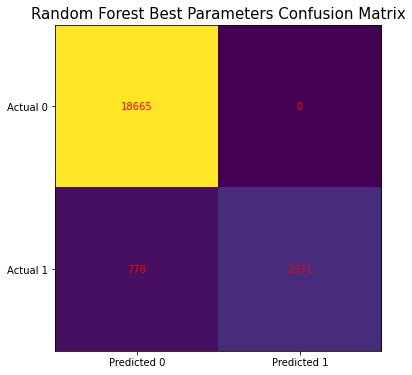

In [ ]:
#get more information on the accuracy of the model with a confusion matrix
#create the confusion matrix
cm = confusion_matrix(y_train, clf2_prediction)

#visuallize the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0', 'Predicted 1'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0', 'Actual 1'))
ax.set_title('Random Forest Best Parameters Confusion Matrix', fontsize=15)

ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

Area under the ROC curve: 0.990


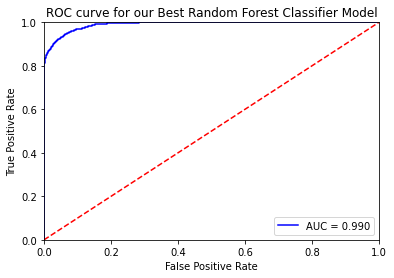

In [ ]:
#probability
proba = clf2_gridsearch.predict_proba(x_train_final)

# Producing the same false/true positive data via a library and plotting it
fpr, tpr, _ = metrics.roc_curve(y_train,proba[:,1])
auc_rf_best = metrics.roc_auc_score(y_train,proba[:,1])


## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.3f'% auc_rf_best)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC curve for our Best Random Forest Classifier Model")

print('Area under the ROC curve: {:.3f}'.format(auc_rf_best))

In [ ]:
#improvement result
result = pd.DataFrame([['GBM', auc_boosting, auc_boosting_best],
                       ['Random Forest', roc_auc_rfc, auc_rf_best]],
                      columns = ['Model', 'AUC', 'AUC_GridSearch'])

result

,Model,AUC,AUC_GridSearch
0,GBM,0.875784,0.999910
1,Random Forest,0.871512,0.990328


#Conclusion

* When using GridSearch for exploring hyper parameters, I find out the best 
parameter for GBM is {'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 5,
 'n_estimators': 41}
 a nd Random Forest is {'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 50}
* The optimized model achieved an ROC is 99.5%, which improves from 87.5% of the regular boosting classifier model. The big take away here is that a bigger AUC score will generally correspond to a better model.
* The optimized model achieved an ROC is 99.9%, which improves from 87.2% of the regular random forest classifier model. The big take away here is that a bigger AUC score will generally correspond to a better model.